# LIS Cheating - Regression Modeling

Andrew Chung, hc893, 02/18/2025

Implementation of basic linear regression model (and others, if time allows) for `pDockQ`, `ipTM`, and `LIS`.

In [102]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score

Import AF3 PPI Prediction Data

In [103]:
af3 = pd.read_csv("af3_metric_experiments.csv")[[
  'ppi', 'SC_LIS', 'SLIRS', 'ICS_bin', 'ICS_log', 'LIS', 'PWID', 
  'LIP', 'pDockQ', 'ipTM', 'pdockq2_mean', 'ranking_confidence', 'ZIES',
  'non_struct_label', 'str_label'
]]
# coerce type np.int64
af3[['non_struct_label', 'str_label']] = af3[['non_struct_label', 'str_label']].astype(np.int64)

# filter for ground truth variables (1 = HINT-binary-HQ-LC, 0 = non-interacting pairs); remove -1
nonstr_ = af3[af3['non_struct_label'] > -1].drop(columns = ['str_label']).rename(columns = {'non_struct_label': 'label'})
str_ = af3[af3['str_label'] > -1].drop(columns = ['non_struct_label']).rename(columns = {'str_label': 'label'})

In [104]:
# get counts of 1 and 0 labels
print("Counts for non-structural: {}".format(nonstr_['label'].value_counts()))
print("Counts for structural: {}".format(str_['label'].value_counts()))

Counts for non-structural: label
0    3872
1    1268
Name: count, dtype: int64
Counts for structural: label
0    2781
1     856
Name: count, dtype: int64


- Now, the task is to find the optimal coefficients $\mathbf{b}$ for each of the three scores. Since the ground truth is binary (**nonstructural/structural label**), a logistic regression model and/or other classifiers would be ideal. That is, the final predicted value (PPI prediction score) can be calculated as $$\text{score} = \operatorname{logit}^{-1}(\mathbf{Xb})$$ where $\mathbf{X}$ stores the three metrics (`pDockQ`, `ipTM`, and `LIS`) in matrix form.
- Here, I will make the assumption that some information is shared between `pDockQ`, `ipTM`, and `LIS`, so a **L2 regularization term** with cross-validation could be used to reduce multicollinearity.

## Non-Structural PPIs

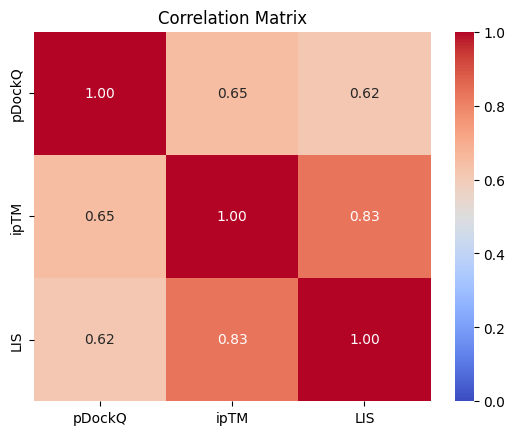

In [105]:
X_ns = nonstr_[['pDockQ', 'ipTM', 'LIS']]
y_ns = nonstr_['label']

# correlation heatmap for prediction metrics
sns.heatmap(X_ns.corr(), annot=True, vmin = 0, vmax = 1, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Fit Logistic Regression Model

In [106]:
glm_ns = LogisticRegressionCV(cv = 5, penalty = 'l2', random_state = 893)
glm_ns.fit(X_ns, y_ns)
betas = np.concatenate((glm_ns.intercept_, glm_ns.coef_[0]))
nonstr_['model'] = glm_ns.predict_proba(X_ns)[:, 1] # store predicted scores
print("Parameters: {}".format(betas))

Parameters: [-2.10424745  1.81726864  0.67829858  5.05500987]


### ROC Curve, AUC

AUC for LIS: 0.7020364397306882
AUC for model: 0.7049033178428971


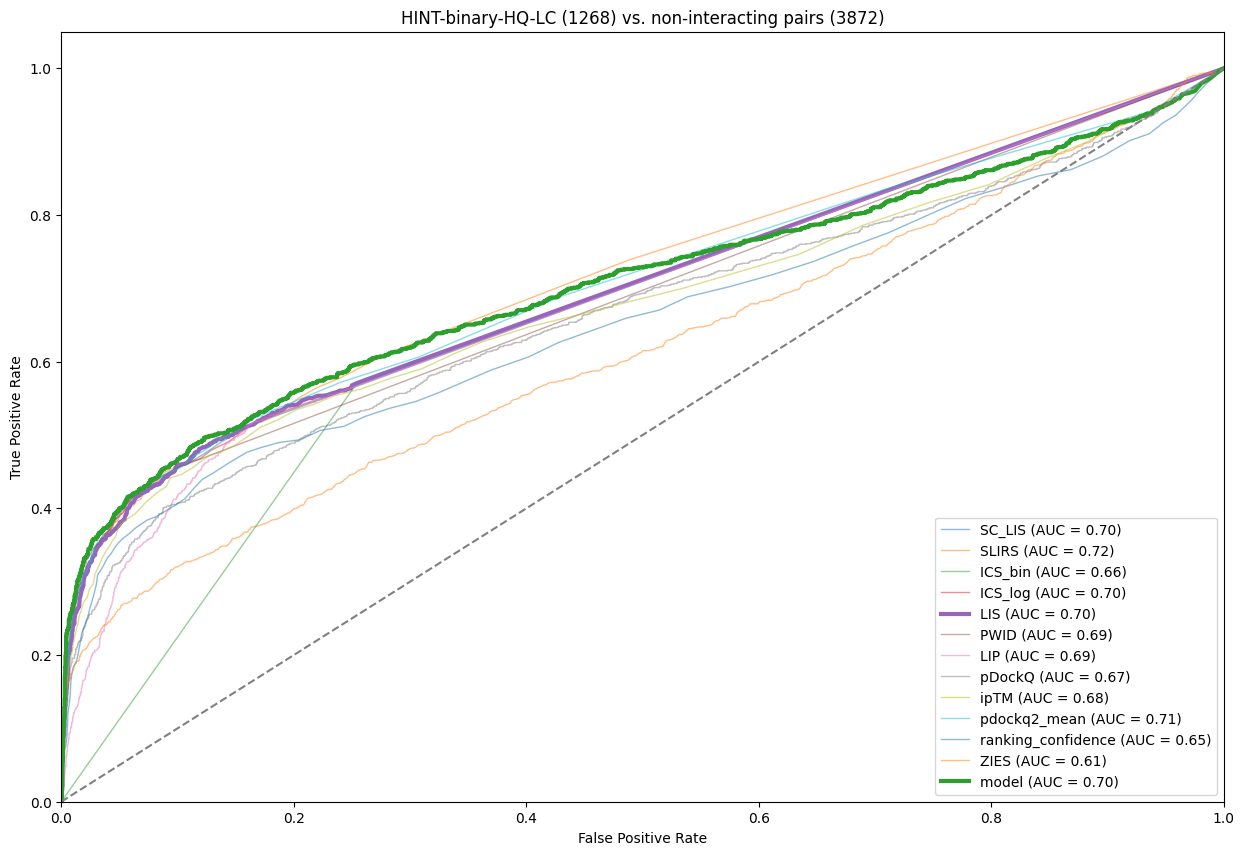

In [107]:
y_true = nonstr_['label']  # Binary response (0 or 1)

# Multiple predictors (scaled 0-1)
predictors = {
  metric : nonstr_[metric] for metric in np.array(nonstr_.columns) if metric not in ['ppi', 'label']
}

plt.figure(figsize=(15,10))

# Plot ROC curves for each predictor
for label, y_score in predictors.items():
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 
      lw= 3 if label in ['model', 'LIS'] else 1, 
      alpha = 1 if label in ['model', 'LIS'] else 0.5, 
      label=f'{label} (AUC = {roc_auc:.2f})'
    )
    if label in ['model', 'LIS']:
      print("AUC for {}: {}".format(label, roc_auc))

# Plot reference line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('HINT-binary-HQ-LC ({}) vs. non-interacting pairs ({})'.format(
  (nonstr_['label'] == 1).sum(), (nonstr_['label'] == 0).sum()
))
plt.legend(loc='lower right')
plt.show()

### PR Curve

PR for LIS: 0.5481150021242001
PR for model: 0.5909621475763986


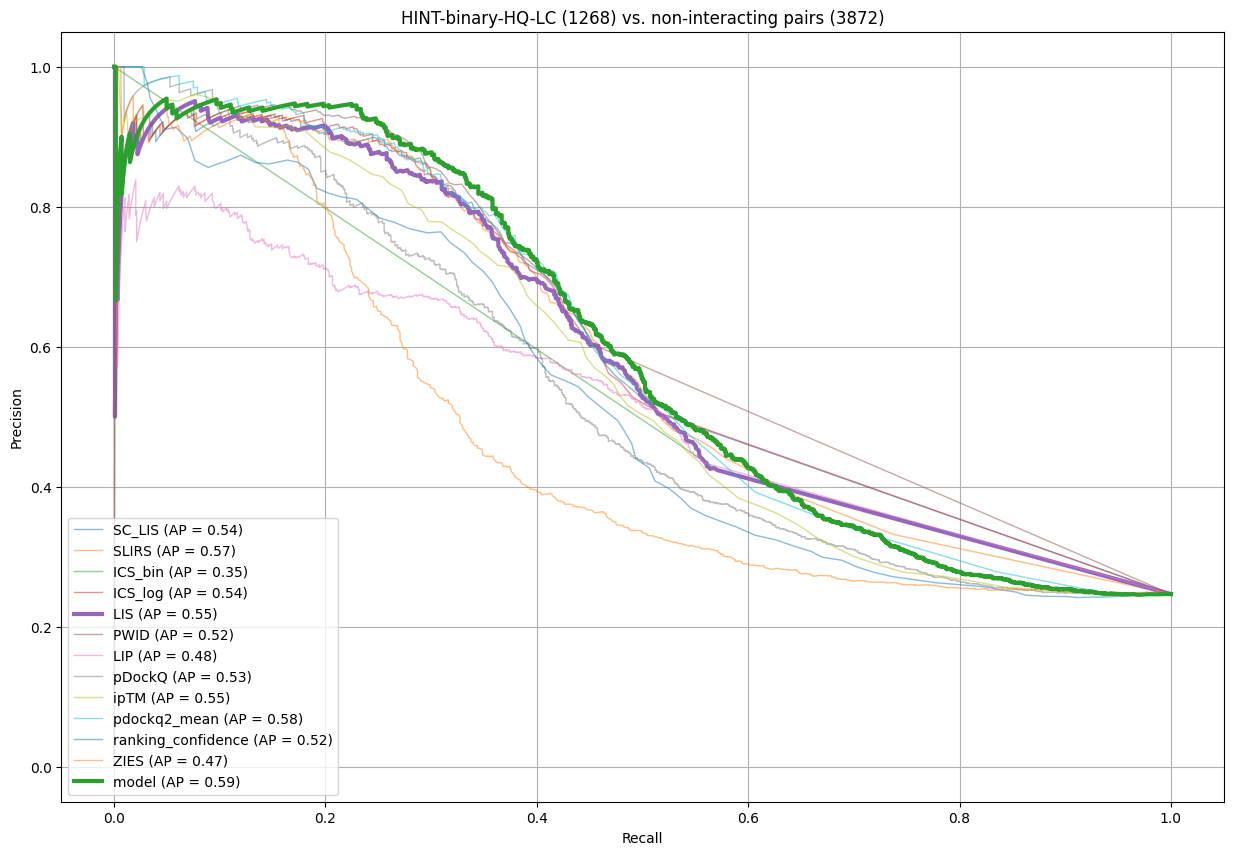

In [108]:
y_true = nonstr_['label']
plt.figure(figsize = (15,10))

for label, y_score in predictors.items():
  precision, recall, _ = precision_recall_curve(y_true, y_score)
  avg_precision = average_precision_score(y_true, y_score)
  plt.plot(recall, precision, 
    lw= 3 if label in ['model', 'LIS'] else 1, 
    alpha = 1 if label in ['model', 'LIS'] else 0.5, 
    label=f'{label} (AP = {avg_precision:.2f})'
  )

  if label in ['model', 'LIS']:
      print("PR for {}: {}".format(label, avg_precision))

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('HINT-binary-HQ-LC ({}) vs. non-interacting pairs ({})'.format(
  (nonstr_['label'] == 1).sum(), (nonstr_['label'] == 0).sum()
))
plt.legend(loc="lower left")
plt.grid(True)

# Show the plot
plt.show()

## Structural PPIs

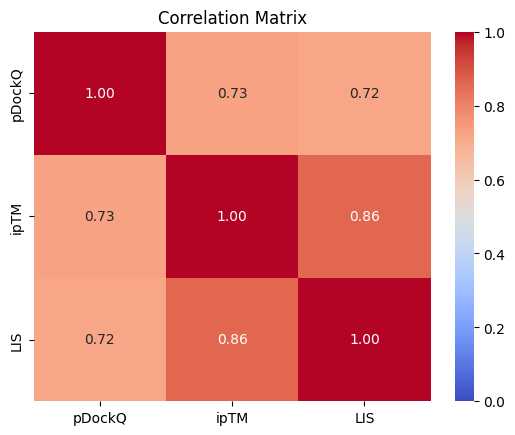

In [109]:
X_s = str_[['pDockQ', 'ipTM', 'LIS']]
y_s = str_['label']

# correlation heatmap for prediction metrics
sns.heatmap(X_s.corr(), annot=True, vmin = 0, vmax = 1, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Fit Logistic Regression Model

In [110]:
glm_s = LogisticRegressionCV(cv = 5, penalty = 'l2', random_state = 893)
glm_s.fit(X_s, y_s)
betas = np.concatenate((glm_s.intercept_, glm_s.coef_[0]))
str_['model'] = glm_s.predict_proba(X_s)[:, 1] # store predicted scores
print("Parameters: {}".format(betas))

Parameters: [-2.53504336  3.55338557  2.2422843   2.2135992 ]


### ROC Curve, AUC

AUC for LIS: 0.7618160363884436
AUC for model: 0.8273231322693714


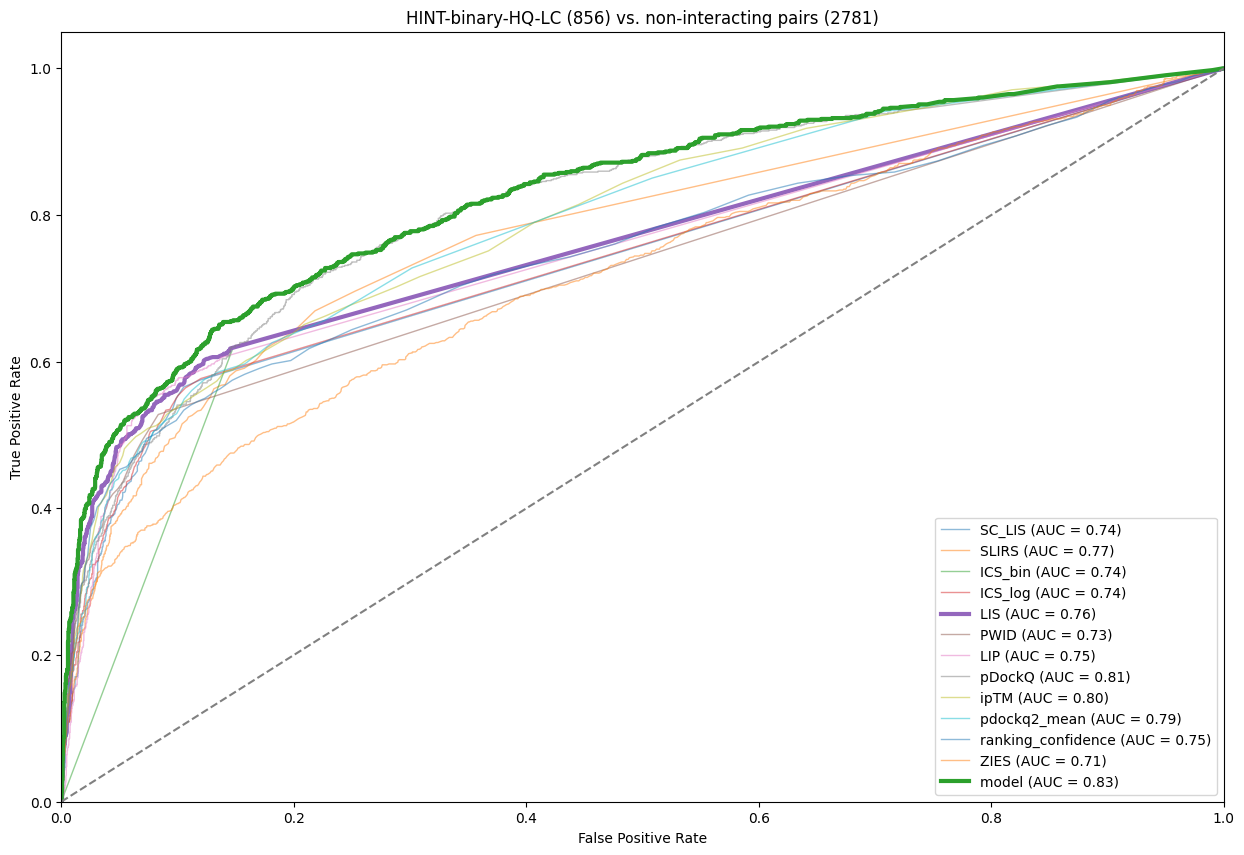

In [111]:
y_true = str_['label']  # Binary response (0 or 1)

# Multiple predictors (scaled 0-1)
predictors = {
  metric : str_[metric] for metric in np.array(str_.columns) if metric not in ['ppi', 'label']
}

plt.figure(figsize=(15,10))

# Plot ROC curves for each predictor
for label, y_score in predictors.items():
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 
      lw= 3 if label in ['model', 'LIS'] else 1, 
      alpha = 1 if label in ['model', 'LIS'] else 0.5, 
      label=f'{label} (AUC = {roc_auc:.2f})'
    )

    if label in ['model', 'LIS']:
      print("AUC for {}: {}".format(label, roc_auc))

# Plot reference line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('HINT-binary-HQ-LC ({}) vs. non-interacting pairs ({})'.format(
  (str_['label'] == 1).sum(), (str_['label'] == 0).sum()
))
plt.legend(loc='lower right')
plt.show()

### PR Curve

PR for LIS: 0.5919297527848006
PR for model: 0.6859110609747555


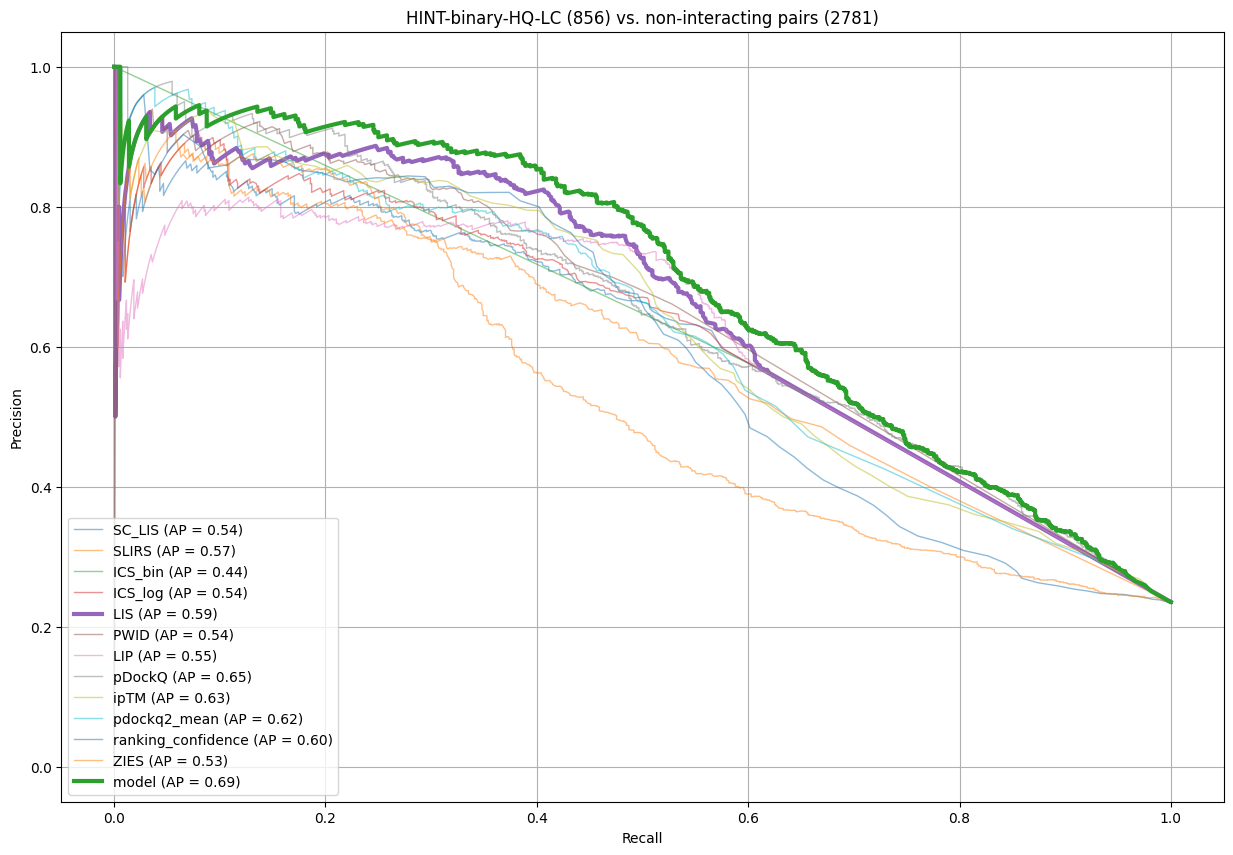

In [112]:
y_true = str_['label']
plt.figure(figsize = (15,10))

for label, y_score in predictors.items():
  precision, recall, _ = precision_recall_curve(y_true, y_score)
  avg_precision = average_precision_score(y_true, y_score)
  plt.plot(recall, precision, 
    lw= 3 if label in ['model', 'LIS'] else 1, 
    alpha = 1 if label in ['model', 'LIS'] else 0.5, 
    label=f'{label} (AP = {avg_precision:.2f})'
  )
  if label in ['model', 'LIS']:
      print("PR for {}: {}".format(label, avg_precision))

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('HINT-binary-HQ-LC ({}) vs. non-interacting pairs ({})'.format(
  (str_['label'] == 1).sum(), (str_['label'] == 0).sum()
))
plt.legend(loc="lower left")
plt.grid(True)

# Show the plot
plt.show()

## Summary

$\text{AU(LIS, Model)}$ Comparison

||Non-Structural|Structural|
|---|---|---|
|$\text{ROC}$|$(0.702, 0.704)$|$(0.548, 0.591)$|
|$\text{PR}$|$(0.762, 0.827)$|$(0.592, 0.686)$|

Parameter Values $(\beta_0, \beta_\text{pDockQ}, \beta_\text{ipTM}, \beta_\text{LIS})$

- **Non-Structural**: $(-2.10424745, 1.81726864, 0.67829858, 5.05500987)$
- **Structural**: $(-2.53504336, 3.55338557, 2.2422843, 2.2135992)$